In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader

import cv2
import os

import matplotlib.pyplot as plt  # For displaying images
import numpy as np
import random  # Import random

import math

class RotaryEmbedding(nn.Module):
    def __init__(self, dim, max_seq_len=3072):
        super().__init__()
        inv_freq = 1.0 / (10000 ** (torch.arange(0, dim, 2).float() / dim))
        position = torch.arange(max_seq_len).float()
        sinusoid_inp = torch.einsum("i,j->ij", position, inv_freq)
        emb = torch.cat((sinusoid_inp.sin(), sinusoid_inp.cos()), dim=-1)
        self.register_buffer('emb', emb)

    def forward(self, x):
        return self.emb[:x.shape[1], :]

def rotate_half(x):
    x1, x2 = x[..., :x.shape[-1]//2], x[..., x.shape[-1]//2:]
    return torch.cat((-x2, x1), dim=-1)

def apply_rotary_embedding(q, k, rope_emb):
    # Reshape rope embeddings to match query and key shapes
    rope_emb = rope_emb.unsqueeze(0).unsqueeze(0)  # [1, 1, seq_len, dim]

    # Apply rotary embeddings
    q_rope = (q * rope_emb.cos()) + (rotate_half(q) * rope_emb.sin())
    k_rope = (k * rope_emb.cos()) + (rotate_half(k) * rope_emb.sin())
    return q_rope, k_rope

class RotaryMultiheadAttention(nn.Module):
    def __init__(self, embed_dim, num_heads):
        super().__init__()
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.head_dim = embed_dim // num_heads
        assert self.head_dim * num_heads == self.embed_dim, "embed_dim must be divisible by num_heads"

        self.q_proj = nn.Linear(embed_dim, embed_dim)
        self.k_proj = nn.Linear(embed_dim, embed_dim)
        self.v_proj = nn.Linear(embed_dim, embed_dim)
        self.out_proj = nn.Linear(embed_dim, embed_dim)

        self.rope = RotaryEmbedding(self.head_dim)

    def forward(self, x):
        batch_size, seq_len, _ = x.shape

        # Project queries, keys, and values and reshape
        q = self.q_proj(x).reshape(batch_size, seq_len, self.num_heads, self.head_dim)
        k = self.k_proj(x).reshape(batch_size, seq_len, self.num_heads, self.head_dim)
        v = self.v_proj(x).reshape(batch_size, seq_len, self.num_heads, self.head_dim)

        # Get rotary embeddings for the sequence length
        rope_emb = self.rope(x)  # [seq_len, head_dim]

        # Apply rotary embeddings to each head separately
        q_rotated = []
        k_rotated = []

        for head in range(self.num_heads):
            q_head = q[..., head, :]  # [batch_size, seq_len, head_dim]
            k_head = k[..., head, :]  # [batch_size, seq_len, head_dim]

            q_head_rot, k_head_rot = apply_rotary_embedding(q_head, k_head, rope_emb)
            q_rotated.append(q_head_rot)
            k_rotated.append(k_head_rot)

        # Stack the rotated heads back together
        q = torch.stack(q_rotated, dim=2)  # [batch_size, seq_len, num_heads, head_dim]
        k = torch.stack(k_rotated, dim=2)  # [batch_size, seq_len, num_heads, head_dim]

        # Reshape for attention computation
        q = q.transpose(1, 2)  # [batch_size, num_heads, seq_len, head_dim]
        k = k.transpose(1, 2)
        v = v.transpose(1, 2)

        # Compute attention
        scores = torch.matmul(q, k.transpose(-2, -1)) / math.sqrt(self.head_dim)
        attn = F.softmax(scores, dim=-1)

        # Apply attention to values
        out = torch.matmul(attn, v)  # [batch_size, num_heads, seq_len, head_dim]
        out = out.transpose(1, 2)  # [batch_size, seq_len, num_heads, head_dim]
        out = out.reshape(batch_size, seq_len, self.embed_dim)

        return self.out_proj(out)

class RotaryTransformerEncoderLayer(nn.Module):
    def __init__(self, d_model, nhead, dim_feedforward=2048, dropout=0.1):
        super().__init__()
        self.self_attn = RotaryMultiheadAttention(d_model, nhead)
        self.linear1 = nn.Linear(d_model, dim_feedforward)
        self.dropout = nn.Dropout(dropout)
        self.linear2 = nn.Linear(dim_feedforward, d_model)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.dropout1 = nn.Dropout(dropout)
        self.dropout2 = nn.Dropout(dropout)

    def forward(self, src):
        src2 = self.norm1(src)
        src2 = self.self_attn(src2)
        src = src + self.dropout1(src2)
        src2 = self.norm2(src)
        src2 = self.linear2(self.dropout(F.relu(self.linear1(src2))))
        src = src + self.dropout2(src2)
        return src

# VAE Encoder (Se)
class VAEEncoder(nn.Module):
    def __init__(self, in_channels=3, hidden_dim=512, latent_dim=512):
        super(VAEEncoder, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, 64, kernel_size=4, stride=2, padding=1)  # 1024 -> 512
        self.conv2 = nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1)  # 512 -> 256
        self.conv3 = nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1)  # 256 -> 128
        self.conv4 = nn.Conv2d(256, hidden_dim, kernel_size=4, stride=2, padding=1)  # 128 -> 64
        self.fc_mu = nn.Linear(hidden_dim * 16 * 16, latent_dim)  # compressed to latent space
        self.fc_logvar = nn.Linear(hidden_dim * 16 * 16, latent_dim)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = x.view(x.size(0), -1)  # flatten
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)
        return mu, logvar

# VAE Decoder (Si)
class VAEDecoder(nn.Module):
    def __init__(self, latent_dim=512, hidden_dim=512, out_channels=3):
        super(VAEDecoder, self).__init__()
        self.fc = nn.Linear(latent_dim, hidden_dim * 16 * 16)
        self.conv1 = nn.ConvTranspose2d(hidden_dim, 256, kernel_size=4, stride=2, padding=1)
        self.conv2 = nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1)
        self.conv3 = nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1)
        self.conv4 = nn.ConvTranspose2d(64, out_channels, kernel_size=4, stride=2, padding=1)

    def forward(self, z):
        x = self.fc(z)
        x = x.view(-1, 512, 16, 16)  # reshape back to image size
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = torch.sigmoid(self.conv4(x))  # output image
        return x

class TemporalTransformer(nn.Module):
    def __init__(self, seq_len=240, embed_dim=512, num_heads=8, depth=6):
        super().__init__()
        self.layers = nn.ModuleList([
            RotaryTransformerEncoderLayer(embed_dim, num_heads)
            for _ in range(depth)
        ])
        self.fc = nn.Linear(embed_dim, embed_dim)

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        cond_embedding = self.fc(x[:, -1, :])
        return x, cond_embedding


class DiffusionTransformer(nn.Module):
    def __init__(self, latent_dim=512, num_tokens=16*16, diffusion_steps=10, num_heads=8, depth=6):
        super().__init__()
        self.latent_dim = latent_dim
        self.num_tokens = num_tokens
        self.diffusion_steps = diffusion_steps

        self.layers = nn.ModuleList([
            RotaryTransformerEncoderLayer(latent_dim, num_heads)
            for _ in range(depth)
        ])
        self.fc_out = nn.Linear(latent_dim, latent_dim)

    def forward(self, cond_embedding):
        batch_size = cond_embedding.size(0)
        latent_tokens = torch.zeros(batch_size, self.num_tokens, self.latent_dim).to(cond_embedding.device)

        for step in range(self.diffusion_steps):
            # Apply transformer layers with RoPE
            for layer in self.layers:
                latent_tokens = layer(latent_tokens)

            # Apply conditional embedding
            latent_tokens[:, -1, :] = cond_embedding

            # Linear projection
            latent_tokens = self.fc_out(latent_tokens)

        decoded_input = latent_tokens.mean(dim=1)
        return decoded_input

class WorldModel(nn.Module):
    def __init__(self):
        super(WorldModel, self).__init__()
        self.encoder = VAEEncoder()
        self.temporal_transformer = TemporalTransformer()
        self.diffusion_transformer = DiffusionTransformer()
        self.decoder = VAEDecoder()

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        # VAE Encoding (Se)
        mu, logvar = self.encoder(x)
        z = self.reparameterize(mu, logvar)

        # Reshape z to match the expected transformer input (batch_size, seq_len, embed_dim)
        z_seq = z.view(x.size(0), -1, 512)

        # Temporal Transformer (Ni)
        hidden_states, cond_embedding = self.temporal_transformer(z_seq)

        # Diffusion Transformer (Ne)
        decoded_input = self.diffusion_transformer(cond_embedding)  # Get reshaped latent

        # VAE Decoding (Si)
        output = self.decoder(decoded_input)  # Decode the reshaped latent

        return output, mu, logvar

def vae_loss(recon_x, x, mu, logvar):
    recon_loss = F.mse_loss(recon_x, x, reduction='sum')
    # KL divergence loss
    kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return recon_loss + kl_loss

In [2]:
class VideoDataset(Dataset):
    def __init__(self, video_path, phase, clip_len=240, stride=120, frame_size=(256, 256), transform=None):
        self.video_path = video_path
        self.clip_len = clip_len
        self.stride = stride
        self.frame_size = frame_size
        self.transform = transform
        self.phase = phase

        if not os.path.exists(self.video_path):
            raise FileNotFoundError(f"Video file not found: {self.video_path}")

        self.total_frames = self._get_total_frames(self.video_path)

    def _get_total_frames(self, video_path):
        cap = cv2.VideoCapture(video_path)
        total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
        cap.release()
        return total_frames

    def __len__(self):
        if self.phase == 1:  # For VAE training, use the entire video
            # Ensure the result is non-negative by using max(0, ...)
            length = (self.total_frames - self.clip_len) // self.stride + 1
            # Print length to check if it's 0
            print(f"Dataset length (phase 1): {length}")  # Add this line for debugging
            return max(0, length)  # Return 0 if length is negative
        else:  # For transformer and full model training, predict the last frame
            # Ensure the result is non-negative by using max(0, ...)
            length = self.total_frames - self.clip_len  # Number of possible starting frames
            # Print length to check if it's 0
            print(f"Dataset length (phase 2/3): {length}")  # Add this line for debugging
            return max(0, length)  # Return 0 if length is negative


    def __getitem__(self, idx):

        cap = cv2.VideoCapture(self.video_path)

        if self.phase == 1:  # VAE training (return clips)
            start_frame = idx * self.stride
            clip = []
            for i in range(self.clip_len):
                cap.set(cv2.CAP_PROP_POS_FRAMES, start_frame + i)
                ret, frame = cap.read()
                if not ret:
                    frame = torch.zeros(3, *self.frame_size, dtype=torch.uint8)
                else:
                    frame = torch.from_numpy(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)).permute(2, 0, 1)
                    frame = transforms.functional.resize(frame, self.frame_size)
                clip.append(frame)
            clip = torch.stack(clip)

        else: # Transformer and full model training (return sequence and target last frame)
            start_frame = idx
            clip = [] #Sequence
            for i in range(self.clip_len): # Sequence frames
                cap.set(cv2.CAP_PROP_POS_FRAMES, start_frame + i)
                ret, frame = cap.read()
                if not ret:
                    frame = torch.zeros(3, *self.frame_size, dtype=torch.uint8)
                else:
                    frame = torch.from_numpy(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)).permute(2, 0, 1)
                    frame = transforms.functional.resize(frame, self.frame_size)
                clip.append(frame)

            cap.set(cv2.CAP_PROP_POS_FRAMES, start_frame + self.clip_len) # Target frame
            ret, target_frame = cap.read()
            if not ret:
                target_frame = torch.zeros(3, *self.frame_size, dtype=torch.uint8)
            else:
                target_frame = torch.from_numpy(cv2.cvtColor(target_frame, cv2.COLOR_BGR2RGB)).permute(2, 0, 1)
                target_frame = transforms.functional.resize(target_frame, self.frame_size)
            clip = torch.stack(clip)

        cap.release()


        if self.transform:
            if self.phase == 1:
                clip = self.transform(clip)
            else:
                clip = self.transform(clip)
                target_frame = self.transform(target_frame)


        if self.phase == 1:
          return clip
        else:
          return clip, target_frame

video_path = "loop.mp4"  # Provide the local path to your video file

video_transform = transforms.Compose([
    transforms.Lambda(lambda x: x / 255.0),  # Normalize to [0, 1]
    transforms.ConvertImageDtype(torch.float)
])


In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = WorldModel().to(device)

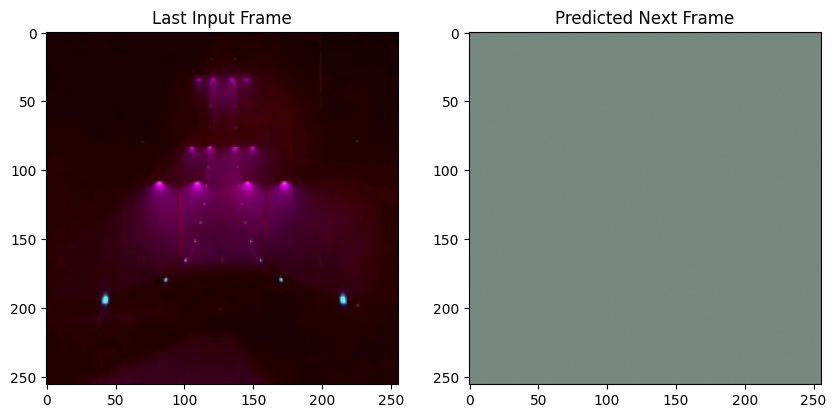

In [4]:
model.eval()  # Set the model to evaluation mode

def process_video_clip(video_path, clip_len=8, frame_size=(256, 256)):
    cap = cv2.VideoCapture(video_path)
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

    # Get clip_len random frame indices
    frame_indices = random.sample(range(total_frames), clip_len)
    frame_indices.sort()  # Sort to maintain temporal order within the random sequence

    frames = []
    for i in frame_indices:
        cap.set(cv2.CAP_PROP_POS_FRAMES, i)
        ret, frame = cap.read()
        if not ret:
            # Handle end of video or invalid frame index (pad with zeros or break)
            frame = np.zeros((frame_size[1], frame_size[0], 3), dtype=np.uint8)
        frame = torch.from_numpy(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)).permute(2, 0, 1)
        frame = transforms.functional.resize(frame, frame_size)
        frames.append(frame)
    cap.release()
    clip = torch.stack(frames).to(device)
    clip = video_transform(clip)
    return clip

# Load and process the video clip
input_clip = process_video_clip(video_path)

with torch.no_grad():  # No need to calculate gradients during inference
    predicted_next_frame, _, _ = model(input_clip) # Get the predicted next frame

    # Select the last predicted frame from the sequence (if it's a sequence)
    predicted_next_frame = predicted_next_frame[-1]

# Convert the predicted frame to a displayable format
predicted_next_frame = predicted_next_frame.squeeze(0).cpu().permute(1, 2, 0).numpy()
predicted_next_frame = (predicted_next_frame * 255).astype(np.uint8)  # Convert back to 0-255 range
predicted_next_frame = cv2.cvtColor(predicted_next_frame, cv2.COLOR_RGB2BGR)  # Convert back to BGR


# Get the last frame of the input clip for comparison (convert to same format as predicted frame)
last_input_frame = input_clip[-1].squeeze(0).cpu().permute(1, 2, 0).numpy()
last_input_frame = (last_input_frame*255).astype(np.uint8)
last_input_frame = cv2.cvtColor(last_input_frame, cv2.COLOR_RGB2BGR)

# Display the last input frame and the predicted next frame
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(last_input_frame)
plt.title("Last Input Frame")
plt.subplot(1, 2, 2)
plt.imshow(predicted_next_frame)
plt.title("Predicted Next Frame")
plt.show()

In [5]:
# Phase 1: VAE Training
vae_dataset = VideoDataset(video_path, phase=1, clip_len=12, stride=3, frame_size=(256, 256), transform=video_transform)
vae_dataloader = DataLoader(vae_dataset, batch_size=4, shuffle=True, num_workers=4)

# PHASE 1: Train the VAE (Se and Si)
def train_vae(model, dataloader, optimizer, num_epochs=10, device='cuda'):
    model.train()
    for epoch in range(num_epochs):
        for batch_idx, frames in enumerate(dataloader):
            # Reshape frames to (batch_size * clip_len, channels, height, width)
            frames = frames.view(-1, frames.shape[2], frames.shape[3], frames.shape[4]).to(device)

            optimizer.zero_grad()

            # Forward pass through ONLY VAE encoder and decoder
            mu, logvar = model.encoder(frames)
            z = model.reparameterize(mu, logvar) # Crucial for VAE training
            recon = model.decoder(z)

            # Reshape recon to match the original frames shape for loss calculation
            recon = recon.view(frames.shape[0], -1, recon.shape[1], recon.shape[2], recon.shape[3])

            loss = vae_loss(recon, frames, mu, logvar)

            loss.backward()
            optimizer.step()

            if batch_idx % 10 == 0:
                print(f'Epoch {epoch}/{num_epochs}, Batch {batch_idx}, Loss: {loss.item()}')

    print('Phase 1: VAE training completed!')


# optimizer setup
vae_params = list(model.encoder.parameters()) + list(model.decoder.parameters())
optimizer_vae = torch.optim.Adam(vae_params, lr=1e-4)

# PHASE 1: Train VAE
train_vae(model, vae_dataloader, optimizer_vae, num_epochs=20, device=device)

Dataset length (phase 1): 35
Dataset length (phase 1): 35


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Dataset length (phase 1): 35
Dataset length (phase 1): 35
Dataset length (phase 1): 35


<ipython-input-1-2f1de9e0d883>:240: UserWarning: Using a target size (torch.Size([48, 3, 256, 256])) that is different to the input size (torch.Size([48, 1, 3, 256, 256])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  recon_loss = F.mse_loss(recon_x, x, reduction='sum')


Epoch 0/20, Batch 0, Loss: 79872712.0


<ipython-input-1-2f1de9e0d883>:240: UserWarning: Using a target size (torch.Size([36, 3, 256, 256])) that is different to the input size (torch.Size([36, 1, 3, 256, 256])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  recon_loss = F.mse_loss(recon_x, x, reduction='sum')


Dataset length (phase 1): 35
Dataset length (phase 1): 35
Dataset length (phase 1): 35
Epoch 1/20, Batch 0, Loss: 35532628.0
Dataset length (phase 1): 35
Dataset length (phase 1): 35
Dataset length (phase 1): 35
Epoch 2/20, Batch 0, Loss: 7006662.5
Dataset length (phase 1): 35
Dataset length (phase 1): 35
Dataset length (phase 1): 35
Epoch 3/20, Batch 0, Loss: 4932487.0
Dataset length (phase 1): 35
Dataset length (phase 1): 35
Dataset length (phase 1): 35
Epoch 4/20, Batch 0, Loss: 4201408.0
Dataset length (phase 1): 35
Dataset length (phase 1): 35
Dataset length (phase 1): 35
Epoch 5/20, Batch 0, Loss: 3908560.5
Dataset length (phase 1): 35
Dataset length (phase 1): 35
Dataset length (phase 1): 35
Epoch 6/20, Batch 0, Loss: 3564966.25
Dataset length (phase 1): 35
Dataset length (phase 1): 35
Dataset length (phase 1): 35
Epoch 7/20, Batch 0, Loss: 3465199.25
Dataset length (phase 1): 35
Dataset length (phase 1): 35
Dataset length (phase 1): 35
Epoch 8/20, Batch 0, Loss: 3029298.75
Data

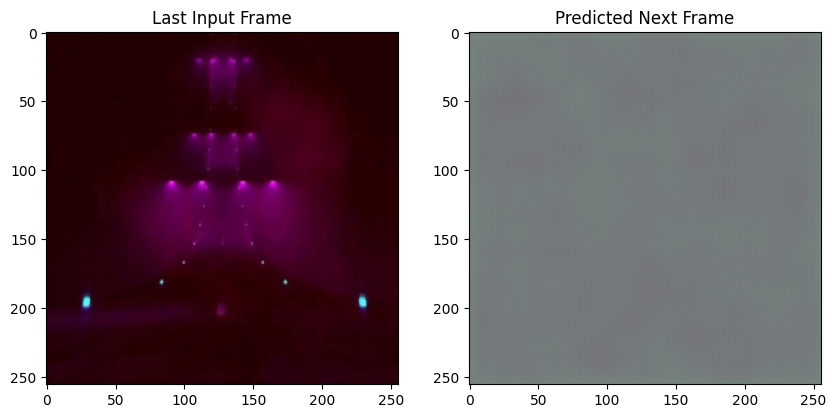

In [6]:
model.eval()  # Set the model to evaluation mode

# Load and process the video clip
input_clip = process_video_clip(video_path)

with torch.no_grad():  # No need to calculate gradients during inference
    predicted_next_frame, _, _ = model(input_clip) # Get the predicted next frame

    # Select the last predicted frame from the sequence (if it's a sequence)
    predicted_next_frame = predicted_next_frame[-1]

# Convert the predicted frame to a displayable format
predicted_next_frame = predicted_next_frame.squeeze(0).cpu().permute(1, 2, 0).numpy()
predicted_next_frame = (predicted_next_frame * 255).astype(np.uint8)  # Convert back to 0-255 range
predicted_next_frame = cv2.cvtColor(predicted_next_frame, cv2.COLOR_RGB2BGR)  # Convert back to BGR


# Get the last frame of the input clip for comparison (convert to same format as predicted frame)
last_input_frame = input_clip[-1].squeeze(0).cpu().permute(1, 2, 0).numpy()
last_input_frame = (last_input_frame*255).astype(np.uint8)
last_input_frame = cv2.cvtColor(last_input_frame, cv2.COLOR_RGB2BGR)

# Display the last input frame and the predicted next frame
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(last_input_frame)
plt.title("Last Input Frame")
plt.subplot(1, 2, 2)
plt.imshow(predicted_next_frame)
plt.title("Predicted Next Frame")
plt.show()

In [7]:
# Phase 2 & 3: Transformer and Full Model Training
transformer_dataset = VideoDataset(video_path, phase=2, clip_len=8, stride=3, frame_size=(256, 256), transform=video_transform)  # Use phase=2 or 3
transformer_dataloader = DataLoader(transformer_dataset, batch_size=1, shuffle=False, num_workers=4)  # Don't shuffle for next-frame prediction

# PHASE 2: Train Transformer (Ni) and Diffusion Transformer (Ne) with VAE Frozen
def train_transformer_with_frozen_vae(model, dataloader, optimizer, num_epochs=10, device='cuda'):
    # Freeze VAE
    for param in model.encoder.parameters():
        param.requires_grad = False
    for param in model.decoder.parameters():
        param.requires_grad = False

    model.train()
    for epoch in range(num_epochs):
        for batch_idx, (clip, target_frame) in enumerate(dataloader): # Unpack the tuple
            clip = clip.to(device) # Move sequence to device
            target_frame = target_frame.to(device) # Move target frame to device
            optimizer.zero_grad()

            # Reshape clip to (batch_size * clip_len, channels, height, width) before passing to the model
            clip_reshaped = clip.view(-1, clip.shape[2], clip.shape[3], clip.shape[4])

            recon, mu, logvar = model(clip_reshaped)  # Pass the reshaped clip to the model
            loss = F.mse_loss(recon, target_frame) # Calculate loss against the target frame

            loss.backward()
            optimizer.step()

            if batch_idx % 10 == 0:
                print(f'Epoch {epoch}/{num_epochs}, Batch {batch_idx}, Loss: {loss.item()}')

    print('Phase 2: Transformer and Diffusion Transformer training with frozen VAE completed!')

transformer_params = list(model.temporal_transformer.parameters()) + list(model.diffusion_transformer.parameters())
optimizer_transformer = torch.optim.Adam(transformer_params, lr=1e-4)

# PHASE 2: Train transformer and diffusion transformer with VAE frozen
train_transformer_with_frozen_vae(model, transformer_dataloader, optimizer_transformer, num_epochs=10, device=device)

Dataset length (phase 2/3): 107


<ipython-input-7-01da6aad994a>:24: UserWarning: Using a target size (torch.Size([1, 3, 256, 256])) that is different to the input size (torch.Size([8, 3, 256, 256])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(recon, target_frame) # Calculate loss against the target frame


Epoch 0/10, Batch 0, Loss: 0.17195996642112732
Epoch 0/10, Batch 10, Loss: 0.012418635189533234
Epoch 0/10, Batch 20, Loss: 0.005917578935623169
Epoch 0/10, Batch 30, Loss: 0.004507220815867186
Epoch 0/10, Batch 40, Loss: 0.002847646828740835
Epoch 0/10, Batch 50, Loss: 0.013020657002925873
Epoch 0/10, Batch 60, Loss: 0.004921768791973591
Epoch 0/10, Batch 70, Loss: 0.0029510806780308485
Epoch 0/10, Batch 80, Loss: 0.013824604451656342
Epoch 0/10, Batch 90, Loss: 0.005071952007710934
Epoch 0/10, Batch 100, Loss: 0.0037838395219296217
Dataset length (phase 2/3): 107
Epoch 1/10, Batch 0, Loss: 0.003169506788253784
Epoch 1/10, Batch 10, Loss: 0.006524405907839537
Epoch 1/10, Batch 20, Loss: 0.005018928553909063
Epoch 1/10, Batch 30, Loss: 0.003909609280526638
Epoch 1/10, Batch 40, Loss: 0.002705970546230674
Epoch 1/10, Batch 50, Loss: 0.013749070465564728
Epoch 1/10, Batch 60, Loss: 0.004334816709160805
Epoch 1/10, Batch 70, Loss: 0.0036306451074779034
Epoch 1/10, Batch 80, Loss: 0.013964

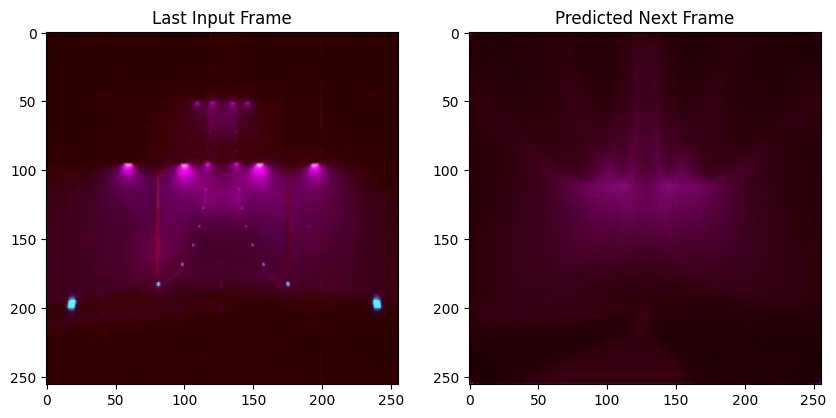

In [8]:
model.eval()  # Set the model to evaluation mode

# Load and process the video clip
input_clip = process_video_clip(video_path)

with torch.no_grad():  # No need to calculate gradients during inference
    predicted_next_frame, _, _ = model(input_clip) # Get the predicted next frame

    # Select the last predicted frame from the sequence (if it's a sequence)
    predicted_next_frame = predicted_next_frame[-1]

# Convert the predicted frame to a displayable format
predicted_next_frame = predicted_next_frame.squeeze(0).cpu().permute(1, 2, 0).numpy()
predicted_next_frame = (predicted_next_frame * 255).astype(np.uint8)  # Convert back to 0-255 range
predicted_next_frame = cv2.cvtColor(predicted_next_frame, cv2.COLOR_RGB2BGR)  # Convert back to BGR


# Get the last frame of the input clip for comparison (convert to same format as predicted frame)
last_input_frame = input_clip[-1].squeeze(0).cpu().permute(1, 2, 0).numpy()
last_input_frame = (last_input_frame*255).astype(np.uint8)
last_input_frame = cv2.cvtColor(last_input_frame, cv2.COLOR_RGB2BGR)

# Display the last input frame and the predicted next frame
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(last_input_frame)
plt.title("Last Input Frame")
plt.subplot(1, 2, 2)
plt.imshow(predicted_next_frame)
plt.title("Predicted Next Frame")
plt.show()

In [9]:
# PHASE 3: Train the whole world model with next-frame prediction
def train_full_model(model, dataloader, optimizer, num_epochs=10, device='cuda'):
    model.train()
    for epoch in range(num_epochs):
        for batch_idx, (clip, target_frame) in enumerate(dataloader): # Unpack the tuple
            clip = clip.to(device) # Move sequence to device
            target_frame = target_frame.to(device) # Move target frame to device
            optimizer.zero_grad()

            # Reshape clip to (batch_size * clip_len, channels, height, width) before passing to the model
            clip_reshaped = clip.view(-1, clip.shape[2], clip.shape[3], clip.shape[4])

            recon, mu, logvar = model(clip_reshaped)  # Pass the reshaped clip to the model
            loss = F.mse_loss(recon, target_frame) # Calculate loss against the target frame

            loss.backward()
            optimizer.step()

            if batch_idx % 10 == 0:
                print(f'Epoch {epoch}/{num_epochs}, Batch {batch_idx}, Loss: {loss.item()}')

    print('Phase 3: Full world model training completed!')

full_model_params = list(model.parameters())  # This includes VAE, temporal transformer, and diffusion transformer
optimizer_full = torch.optim.Adam(full_model_params, lr=1e-5)

# PHASE 3: Fine-tune the full world model
train_full_model(model, transformer_dataloader, optimizer_full, num_epochs=5, device=device)

Dataset length (phase 2/3): 107


<ipython-input-9-ea0d1d5a1be5>:14: UserWarning: Using a target size (torch.Size([1, 3, 256, 256])) that is different to the input size (torch.Size([8, 3, 256, 256])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(recon, target_frame) # Calculate loss against the target frame


Epoch 0/5, Batch 0, Loss: 0.0032791669946163893
Epoch 0/5, Batch 10, Loss: 0.006208581849932671
Epoch 0/5, Batch 20, Loss: 0.004901964217424393
Epoch 0/5, Batch 30, Loss: 0.00283107440918684
Epoch 0/5, Batch 40, Loss: 0.0027396611403673887
Epoch 0/5, Batch 50, Loss: 0.01248824130743742
Epoch 0/5, Batch 60, Loss: 0.004145951010286808
Epoch 0/5, Batch 70, Loss: 0.0033550828229635954
Epoch 0/5, Batch 80, Loss: 0.01377585344016552
Epoch 0/5, Batch 90, Loss: 0.004462917800992727
Epoch 0/5, Batch 100, Loss: 0.0034800106659531593
Dataset length (phase 2/3): 107
Epoch 1/5, Batch 0, Loss: 0.004166117869317532
Epoch 1/5, Batch 10, Loss: 0.00561667000874877
Epoch 1/5, Batch 20, Loss: 0.004880639258772135
Epoch 1/5, Batch 30, Loss: 0.002872306387871504
Epoch 1/5, Batch 40, Loss: 0.00271926773712039
Epoch 1/5, Batch 50, Loss: 0.01264083944261074
Epoch 1/5, Batch 60, Loss: 0.004062305670231581
Epoch 1/5, Batch 70, Loss: 0.0033354766201227903
Epoch 1/5, Batch 80, Loss: 0.01378417294472456
Epoch 1/5, 

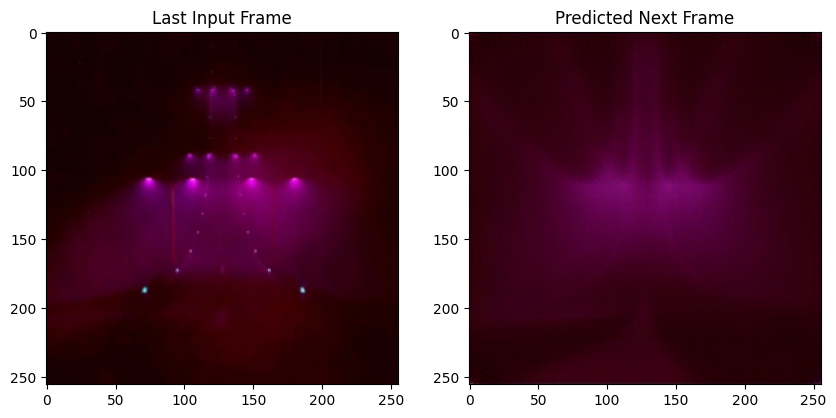

In [15]:
model.eval()  # Set the model to evaluation mode

# Load and process the video clip
input_clip = process_video_clip(video_path)

with torch.no_grad():  # No need to calculate gradients during inference
    predicted_next_frame, _, _ = model(input_clip) # Get the predicted next frame

    # Select the last predicted frame from the sequence (if it's a sequence)
    predicted_next_frame = predicted_next_frame[-1]

# Convert the predicted frame to a displayable format
predicted_next_frame = predicted_next_frame.squeeze(0).cpu().permute(1, 2, 0).numpy()
predicted_next_frame = (predicted_next_frame * 255).astype(np.uint8)  # Convert back to 0-255 range
predicted_next_frame = cv2.cvtColor(predicted_next_frame, cv2.COLOR_RGB2BGR)  # Convert back to BGR


# Get the last frame of the input clip for comparison (convert to same format as predicted frame)
last_input_frame = input_clip[-1].squeeze(0).cpu().permute(1, 2, 0).numpy()
last_input_frame = (last_input_frame*255).astype(np.uint8)
last_input_frame = cv2.cvtColor(last_input_frame, cv2.COLOR_RGB2BGR)

# Display the last input frame and the predicted next frame
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(last_input_frame)
plt.title("Last Input Frame")
plt.subplot(1, 2, 2)
plt.imshow(predicted_next_frame)
plt.title("Predicted Next Frame")
plt.show()